- 该笔记使用神经网络构建推荐模型
- CNN主要是用于处理title
- 模型分为User和Item两部分，每部分最终生成了两个Embedding向量。Item部分的Embedding向量会用于做召回，类似于ItemCF

## 准备数据

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

#### 先用pandas加载电影信息

In [2]:
df_movies = pd.read_csv('../../data/ml-clean/movies_v2.csv', index_col=0, engine= 'python')

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15171 entries, 0 to 15170
Data columns (total 14 columns):
moviename       15171 non-null object
director        15066 non-null object
leadactors      14786 non-null object
screenwriter    0 non-null float64
picture         15171 non-null object
averating       15171 non-null float64
numrating       15171 non-null float64
description     15114 non-null object
typelist        14966 non-null object
backpost        15170 non-null object
movieId         15171 non-null int64
title           15171 non-null object
genres          15171 non-null object
showyear        15166 non-null object
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


#### 加载打分信息

In [4]:
df_ratings = pd.read_csv('../../data/ml-clean/ratings_v2.csv', index_col=0, engine = 'python')

In [5]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15654592 entries, 0 to 15654591
Data columns (total 5 columns):
movieId       int64
userId        int64
rating        float64
timestamp     int64
movie_user    object
dtypes: float64(1), int64(3), object(1)
memory usage: 716.6+ MB


In [6]:
df_ratings = df_ratings.drop('movie_user', axis=1)

#### 用户信息

In [7]:
print('用户数量为：{}'.format(df_ratings['userId'].nunique()))

用户数量为：189911


#### 1.3 对数据特征进行加工

考虑到电影信息中的`title`和`genres`字段值为字符串，其表示的信息为复合信息，需要进行拆解

In [8]:
def prepare_data(df_movies, df_ratings):
    import re
    df_movies = df_movies.copy()
    df_ratings = df_ratings.copy()
    df_movies['title'] = df_movies['moviename']
    df_movies['genres'] = df_movies['genres'].map(lambda x : x.split('|'))
    genres_dict = {}
    for i, genres in enumerate(list(set(df_movies['genres'].sum()))):
        genres_dict[genres] = i + 1
    df_movies['genres'] = df_movies['genres'].map(lambda x : [genres_dict[xx] for xx in x])
    
    df_ratings_users_movies = pd.merge(df_ratings, df_movies, on = 'movieId')

    X_users_id = df_ratings_users_movies[['userId']].values
    # 电影数据(ID)
    X_movies_id = df_ratings_users_movies[['movieId']].values
    # 电影数据(类型)
    from keras.preprocessing.sequence import pad_sequences
    X_movies_genres = pad_sequences(np.array(df_ratings_users_movies['genres'].values.tolist()), padding = 'post')
    # 电影数据（标题）
    from keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_ratings_users_movies['title'])
    X_movies_title = tokenizer.texts_to_sequences(df_ratings_users_movies['title'])
    X_movies_title = pad_sequences(X_movies_title, padding = 'post')
    # 样本标签
    y = df_ratings_users_movies[['rating']].values
    users_id_size = df_ratings_users_movies['userId'].max()
    movies_id_size = df_movies['movieId'].max()
    return X_users_id, X_movies_id, X_movies_genres, X_movies_title, y, \
            users_id_size, movies_id_size, genres_dict, tokenizer.word_index

In [9]:
X_users_id, X_movies_id, X_movies_genres, X_movies_title, y, \
users_id_size, movies_id_size, genres_dict, title_word_index = prepare_data(df_movies, df_ratings)

Using TensorFlow backend.


## 2. 训练模型

- 模型采用神经网络模型，用户特征和电影特征分别训练出两个向量，两个向量之间作内积去预测打分标签。
- 除去电影中的title属性使用卷积运算，其它的特征均作Embedding

#### 2.1 Baseline 模型

In [21]:
def build_model(users_id_size, movies_id_size, genres_n, genres_len, title_n, title_len):
    import keras
    from keras.layers import Input, Dense, Embedding, Flatten, Reshape, Conv1D, MaxPooling1D, Lambda
    from keras.models import Model
    import keras.backend as K
    from keras.regularizers import l2
    from keras.optimizers import Adam
    
    input_users_id = Input(shape = (1,), name = 'users_id')
    
    embedding_users_id = Embedding(users_id_size, 32, embeddings_regularizer=l2(1e-4))(input_users_id)
    embedding_users_id = Flatten()(embedding_users_id)
    
    layer = Dense(128, activation = 'relu', kernel_regularizer=l2(1e-4))(embedding_users_id)
    user_layer = Dense(200, activation = 'relu', kernel_regularizer=l2(1e-4), name='user_output')(layer)
    
    input_movies_id = Input(shape = (1,), name = 'movies_id')
    input_movies_genres = Input(shape = (genres_len,), name = 'movies_genres')
    input_movies_title = Input(shape = (title_len,), name = 'movies_title')
    
    embedding_movies_id = Embedding(movies_id_size, 32, embeddings_regularizer=l2(1e-4))(input_movies_id)
    embedding_movies_id = Flatten()(embedding_movies_id)
    embedding_movies_genres = Embedding(genres_n, 32, input_length = genres_len, embeddings_regularizer=l2(1e-4))(input_movies_genres)
    embedding_movies_genres = Lambda(lambda x : K.sum(x, axis = 1, keepdims = False), output_shape=(32,))(embedding_movies_genres)
    layer = keras.layers.concatenate([embedding_movies_id, embedding_movies_genres])
    movies_layer = Dense(64, activation = 'relu')(layer)
    
    embedding_movies_title = Embedding(title_n, 32, input_length = title_len, embeddings_regularizer=l2(1e-4))(input_movies_title)
    window_sizes = {2, 3, 4, 5}
    conv_list = []
    for window in window_sizes:
        movies_title_conv = Conv1D(filters = 16, kernel_size = window,
                                 padding = 'valid', activation = 'relu',
                                 strides = 1)(embedding_movies_title)
        movies_title_conv = MaxPooling1D(pool_size = (title_len - window + 1))(movies_title_conv)
        movies_title_conv = Flatten()(movies_title_conv)
        conv_list.append(movies_title_conv)
        
    conv_layer = keras.layers.concatenate(conv_list)
    movie_layer = keras.layers.concatenate([movies_layer, conv_layer])
    movie_layer = Dense(200, activation = 'relu', kernel_regularizer=l2(1e-4), name='movie_output')(movie_layer)
    
    output_layer = keras.layers.dot([user_layer, movie_layer], axes = 1)
    
    model = Model(inputs = [input_users_id, input_movies_id,input_movies_genres, input_movies_title], outputs = output_layer)
    
    #adam = Adam(learning_rate=0.1)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model

In [22]:
model = build_model(users_id_size + 1, movies_id_size + 1, 
                    len(genres_dict) + 1, X_movies_genres.shape[1], len(title_word_index) + 1, X_movies_title.shape[1])

In [23]:
#model.summary()

In [24]:
def train(model, X_users_id, X_movies_id, X_movies_genres, X_movies_title, y):
    from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001)
    tensorboard = TensorBoard(log_dir='./tensorboard', write_grads=True, histogram_freq=1, batch_size=2048,
                             update_freq='epoch')
    checkpoint = ModelCheckpoint(filepath='./model', save_best_only=True, save_weights_only=True)
    
    hist = model.fit([X_users_id, X_movies_id, X_movies_genres, X_movies_title], 
              y, epochs = 10, batch_size = 2048, validation_split = 0.3, shuffle = True,
                callbacks=[reduce_lr, tensorboard, checkpoint])
    return hist

In [25]:
hist = train(model, X_users_id, X_movies_id, X_movies_genres, X_movies_title, y)

Train on 10958214 samples, validate on 4696378 samples
Epoch 1/10
10958214/10958214 [==============================] - 851s 78us/step - loss: 0.9058 - val_loss: 1.0777
Epoch 2/10
10958214/10958214 [==============================] - 850s 78us/step - loss: 0.8099 - val_loss: 1.0567
Epoch 3/10
10958214/10958214 [==============================] - 854s 78us/step - loss: 0.7998 - val_loss: 1.0528
Epoch 4/10
10958214/10958214 [==============================] - 856s 78us/step - loss: 0.7966 - val_loss: 1.0572
Epoch 5/10
10958214/10958214 [==============================] - 864s 79us/step - loss: 0.7960 - val_loss: 1.0573
Epoch 6/10
10958214/10958214 [==============================] - 854s 78us/step - loss: 0.7937 - val_loss: 1.0524
Epoch 7/10
10958214/10958214 [==============================] - 866s 79us/step - loss: 0.7924 - val_loss: 1.0692
Epoch 8/10
10958214/10958214 [==============================] - 862s 79us/step - loss: 0.7917 - val_loss: 1.0553
Epoch 9/10
10958214/10958214 [===========

In [30]:
model.save_weights('cnn_model_weights.h5')

- 虽然训练集的误差随着轮次在不断减小，但是第二轮以后，测试集误差却不降反升，说明模型的泛化能力不强

In [26]:
df_hist = pd.DataFrame(hist.history)

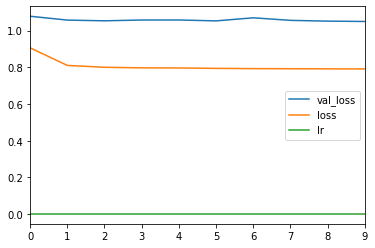

In [31]:
df_hist.plot()

## 获取电影的Embedding向量

In [18]:
def prepare_movies_data(df_movies):
    import re
    df_movies = df_movies.copy()
    df_movies['title'] = df_movies['moviename']
    df_movies['genres'] = df_movies['genres'].map(lambda x : x.split('|'))
    genres_dict = {}
    for i, genres in enumerate(list(set(df_movies['genres'].sum()))):
        genres_dict[genres] = i + 1
    df_movies['genres'] = df_movies['genres'].map(lambda x : [genres_dict[xx] for xx in x])
    
    # 电影数据(ID)
    X_movies_id = df_movies[['movieId']].values
    # 电影数据(类型)
    from keras.preprocessing.sequence import pad_sequences
    X_movies_genres = pad_sequences(np.array(df_movies['genres'].values.tolist()), padding = 'post')
    # 电影数据（标题）
    from keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_movies['title'])
    X_movies_title = tokenizer.texts_to_sequences(df_movies['title'])
    X_movies_title = pad_sequences(X_movies_title, padding = 'post')
    movies_id_size = df_movies['movieId'].max()
    return X_movies_id, X_movies_genres, X_movies_title,\
            movies_id_size, genres_dict, tokenizer.word_index

In [19]:
movie_X_movies_id, movie_X_movies_genres, movie_X_movies_title,\
movie_movies_id_size, movie_genres_dict, movie_title_word_index = prepare_movies_data(df_movies)

In [21]:
from keras.models import Model

In [29]:
#intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('movie_output').output)

In [30]:
intermediate_layer_model = Model(inputs=[model.get_layer('movies_id').input, model.get_layer('movies_genres').input,
                                        model.get_layer('movies_title').input], outputs=model.get_layer('movie_output').output)

In [31]:
movie_embeddings = intermediate_layer_model.predict([movie_X_movies_id, movie_X_movies_genres, movie_X_movies_title])

In [32]:
movie_embeddings.shape

(15171, 200)

In [34]:
df_movies.shape

(15171, 14)

## 使用KNN模型获取每个电影最相近的500个电影

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
from sklearn.metrics.pairwise import cosine_distances

In [66]:
knn = KNeighborsClassifier(n_neighbors=100, metric=lambda x, y : x.dot(y))

In [67]:
y = np.random.random_integers(0, 1, (movie_embeddings.shape[0], 1))

In [68]:
movie_embeddings.shape

(15171, 200)

In [69]:
y.shape

(15171, 1)

In [70]:
knn.fit(movie_embeddings, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
                     metric=<function <lambda> at 0x7f49d172abf8>,
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [74]:
k_idxs = knn.kneighbors(movie_embeddings, return_distance=False)

In [78]:
similar_movieIds = np.array(list(map(lambda x : df_movies['movieId'].values[x], k_idxs)))

In [82]:
df_similar_movieIds = pd.DataFrame(data=similar_movieIds, columns=['sim_{}'.format(i) for i in range(100)])

In [85]:
df_similar_moive_ids = pd.concat([df_movies[['movieId']], df_similar_movieIds], axis=1)

In [88]:
df_similar_moive_ids.to_csv('similar_moive_id.csv')

#### 2.2 优化版本（提高模型的泛化能力）

In [50]:
def build_model(users_id_size, age_size, movies_id_size, genres_n, genres_len, title_n, title_len):
    import keras
    from keras.layers import Input, Dense, Embedding, Flatten, Reshape, Conv1D, MaxPooling1D, Lambda, Activation, Dropout
    from keras.layers.normalization import BatchNormalization
    from keras.optimizers import Adam
    from keras.models import Model
    from keras.regularizers import l2
    import keras.backend as K
    
    input_users_id = Input(shape = (1,), name = 'users_id')
    input_users_gender = Input(shape = (1,), name = 'users_gender')
    input_users_age = Input(shape = (1,), name = 'users_age')
    
    embedding_users_id = Embedding(users_id_size, 32)(input_users_id)
    embedding_users_id = Flatten()(embedding_users_id)
    embedding_users_gender = Embedding(2, 16)(input_users_gender)
    embedding_users_gender = Flatten()(embedding_users_gender)
    embedding_users_age = Embedding(age_size, 16)(input_users_age)
    embedding_users_age = Flatten()(embedding_users_age)
    layer_users_id = Dense(32, activation = 'relu', kernel_regularizer = l2(1e-3))(embedding_users_id)
    layer_users_gender = Dense(32, activation = 'relu', kernel_regularizer = l2(1e-3))(embedding_users_gender)
    layer_users_age = Dense(32, activation = 'relu', kernel_regularizer = l2(1e-3))(embedding_users_age)
    layer = keras.layers.concatenate([layer_users_id, layer_users_gender, layer_users_age])
    user_layer = Dense(200, activation = 'tanh', kernel_regularizer = l2(1e-3))(layer)
    
    input_movies_id = Input(shape = (1,), name = 'movies_id')
    input_movies_genres = Input(shape = (genres_len,), name = 'movies_genres')
    input_movies_title = Input(shape = (title_len,), name = 'movies_title')
    
    embedding_movies_id = Embedding(movies_id_size, 32)(input_movies_id)
    embedding_movies_id = Flatten()(embedding_movies_id)
    embedding_movies_genres = Embedding(genres_n, 32, input_length = genres_len)(input_movies_genres)
    embedding_movies_genres = Lambda(lambda x : K.sum(x, axis = 1, keepdims = False), output_shape=(32,))(embedding_movies_genres)
    
    layer_movies_id = Dense(32, activation = 'relu', kernel_regularizer = l2(1e-3))(embedding_movies_id)
    layer_movies_genres = Dense(32, activation = 'relu', kernel_regularizer = l2(1e-3))(embedding_movies_genres)
    
    
    embedding_movies_title = Embedding(title_n, 32, input_length = title_len)(input_movies_title)
    window_sizes = {2, 3, 4, 5}
    conv_list = []
    for window in window_sizes:
        movies_title_conv = Conv1D(filters = 16, kernel_size = window,
                                 padding = 'valid',
                                 strides = 1, kernel_initializer = 'he_normal',
                                  kernel_regularizer = l2(1e-3))(embedding_movies_title)
        movies_title_conv = BatchNormalization(axis = 2)(movies_title_conv)
        movies_title_conv = Activation('relu')(movies_title_conv)
        movies_title_conv = MaxPooling1D(pool_size = (title_len - window + 1))(movies_title_conv)
        movies_title_conv = Flatten()(movies_title_conv)
        conv_list.append(movies_title_conv)
        
    conv_layer = keras.layers.concatenate(conv_list)
    conv_layer = Dropout(0.5)(conv_layer)
    movie_layer = keras.layers.concatenate([layer_movies_id, layer_movies_genres, conv_layer])
    movie_layer = Dense(200, activation = 'tanh', kernel_regularizer = l2(1e-3))(movie_layer)
    
    output_layer = keras.layers.dot([user_layer, movie_layer], axes = 1)
    
    model = Model(inputs = [input_users_id, input_users_gender, input_users_age, \
                            input_movies_id,input_movies_genres, input_movies_title], output = output_layer)
    
    #optimizer = Adam(lr = 0.0001)
    model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
     
    return model

In [32]:
from keras.utils import plot_model

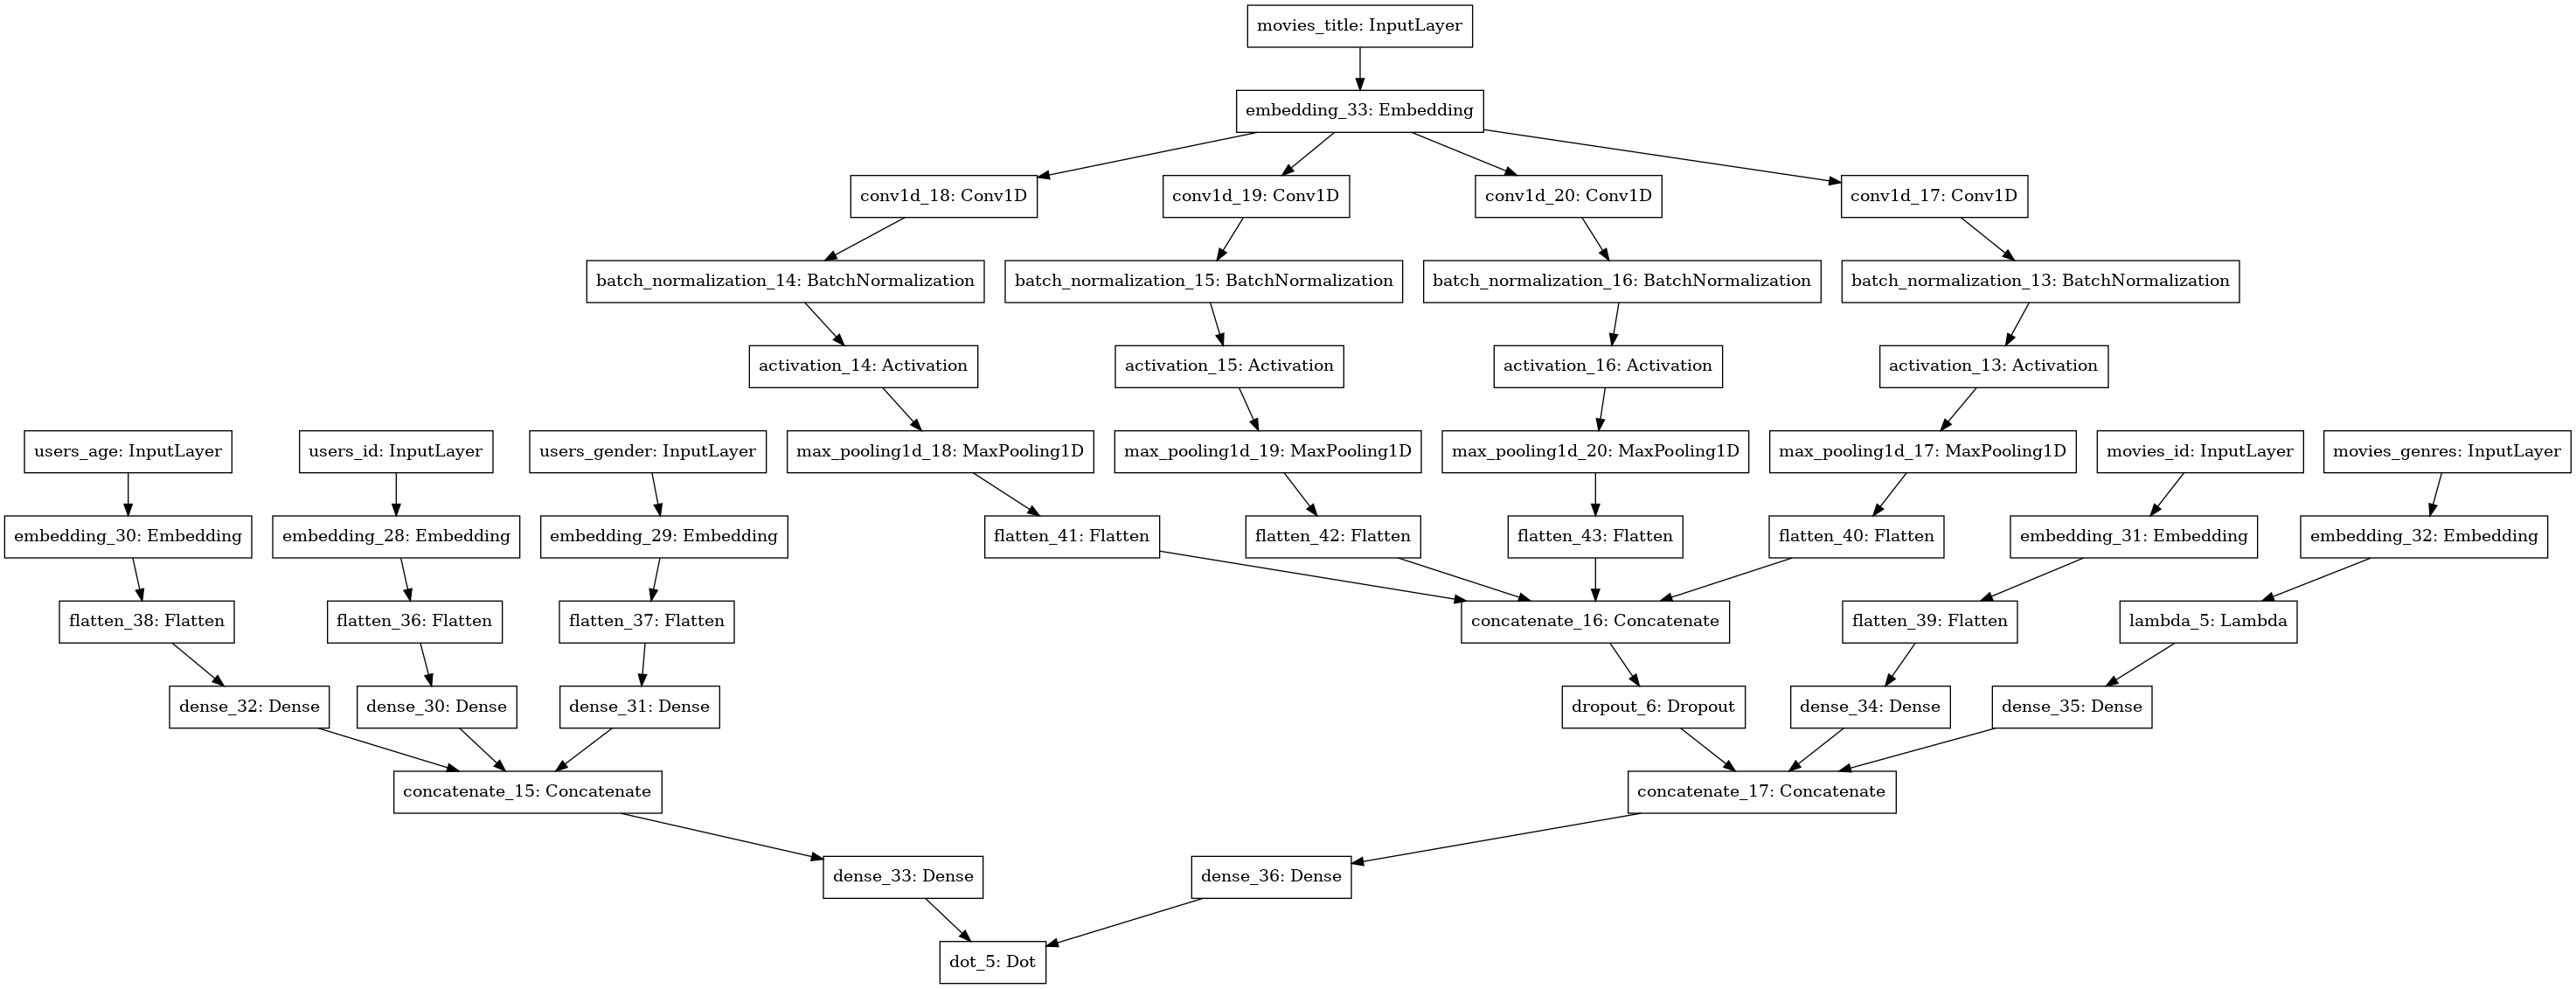

In [41]:
plot_model(model)

In [51]:
model = build_model(users_id_size + 1, len(age_bins) - 1, movies_id_size + 1, 
                    len(genres_dict) + 1, X_movies_genres.shape[1], len(title_word_index) + 1, X_movies_title.shape[1])

In [ ]:
hist = train(model, X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title, y)

Train on 700146 samples, validate on 300063 samples
Epoch 1/10
700146/700146 [==============================] - 220s 314us/step - loss: 0.9266 - val_loss: 1.2074
Epoch 2/10
700146/700146 [==============================] - 234s 334us/step - loss: 0.8365 - val_loss: 1.2830
Epoch 3/10
645504/700146 [==========================>...] - ETA: 15s - loss: 0.8192

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])